#### Cargamos el dataset y normalizamos las columnas

#### Aplicación de K-MEANS al CRISIS
* En este notebook 'KMeans_general', analizamos el dataset general en base a los valores de las etiquetas de los programas presidenciales. PAra cada país, para cada año en que tuvo elecciones, se ponderó cada variable por el % de votos que sacó cada programa; de esta manera tenemos un registro por país por año.
* Dado que hay algunos países en que la suma de las variables 'per' no es 100%, se normalizaron de forma de que sumaran 100%
* A fin de contar con una buena masa de datos, sólo se considerá las variables per principales ('per' + 3 dígitos). En total 46 variables.
* Se aplicó PCA para reducir las dimensiones
* Aplicamos K-MEANS
* Hicimos análisis de los países-años en cada cluster

#### Conclusiones
* Del análisis de clusters se puede obervar que son compuestos por países bien eterogéneos
* Los cluster presentan países que tienen programas de gobierno de múltiples años de manera que cuesta asociar el cluster a la ocurrencia de eventos globales
* 

In [6]:
from sklearn.cluster import KMeans

In [7]:
import pandas as pd
import numpy as np

# Cargar el dataset
file_path = './data/MP_Dataset_KMeans.xlsx'
df = pd.read_excel(file_path)

# Seleccionar columnas relevantes
columns_per = [col for col in df.columns if col.startswith('per')]
columns_relevant = ['agno', 'countryname'] + columns_per
df = df[columns_relevant]

# Validar si las variables `per` suman 1
df['per_sum'] = df[columns_per].sum(axis=1)
rows_to_normalize = df['per_sum'] != 1.0

# Normalizar las filas que no suman 1
df.loc[rows_to_normalize, columns_per] = df.loc[rows_to_normalize, columns_per].div(df.loc[rows_to_normalize, 'per_sum'], axis=0)
df.drop(columns=['per_sum'], inplace=True)

# Verificar la normalización
print(f"¿Todas las filas normalizadas correctamente? {df[columns_per].sum(axis=1).round(6).eq(1).all()}")


¿Todas las filas normalizadas correctamente? True


In [19]:
from sklearn.preprocessing import StandardScaler

# Extraer únicamente las columnas de interés (las columnas 'per')
data_per = df[columns_per]

# Normalizar las columnas 'per'
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_per)

# Convertir a DataFrame para mantener las etiquetas de las columnas
data_normalized = pd.DataFrame(data_normalized, columns=columns_per)

# Verificar la estructura del DataFrame normalizado
# print(data_normalized.head())


#### PCA

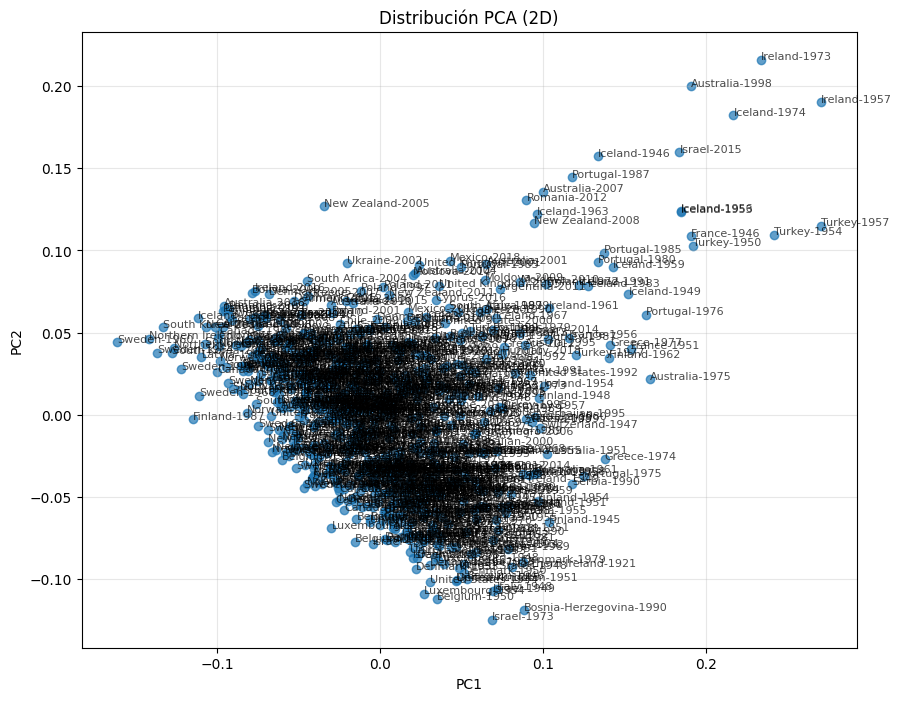

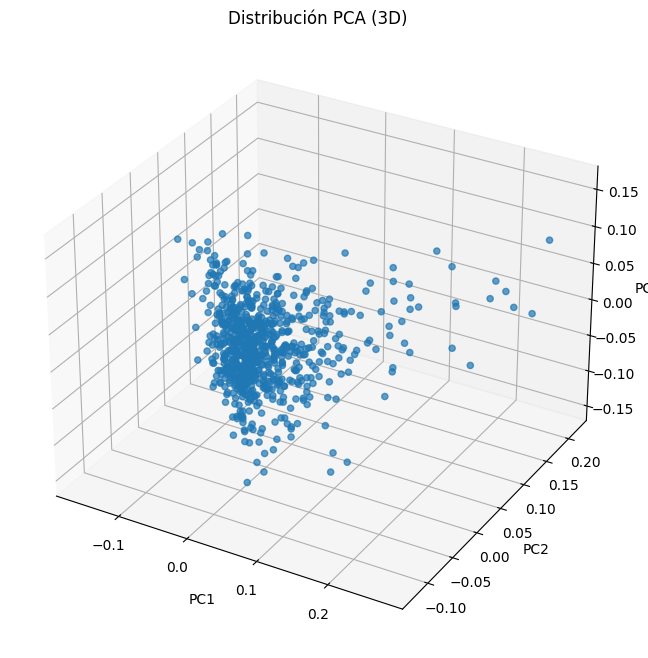

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Realizar PCA
pca = PCA(n_components=3)
components = pca.fit_transform(df[columns_per])
df_pca = pd.DataFrame(components, columns=['PC1', 'PC2', 'PC3'])
df_pca['countryname'] = df['countryname']
df_pca['agno'] = df['agno']

# Gráfico 2D
plt.figure(figsize=(10, 8))
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.7)
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], f"{row['countryname']}-{row['agno']}", fontsize=8, alpha=0.7)
plt.title('Distribución PCA (2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(alpha=0.3)
plt.show()

# Gráfico 3D (opcional)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], alpha=0.7)
ax.set_title('Distribución PCA (3D)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()


In [ ]:
max_k = 10  # Ajusta según el rango deseado

In [11]:
wcss = []  # Lista para almacenar los WCSS
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_normalized)  # Asegúrate de usar los datos normalizados
    wcss.append(kmeans.inertia_)  # Inercia es el WCSS


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

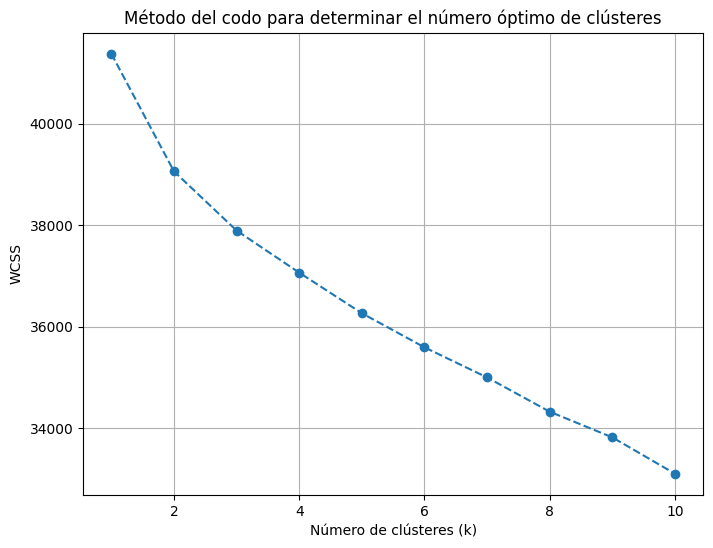

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='--')
plt.title('Método del codo para determinar el número óptimo de clústeres')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('WCSS')
plt.grid()
plt.show()


#### Estimamos un # de clusters inicial con el 'elbow method'
* suma de valores cuadráticos dentro del cluster (WCSS)

In [13]:
from kneed import KneeLocator

# Verificar consistencia de max_k y wcss
print(f"max_k: {max_k}, longitud de wcss: {len(wcss)}")
assert len(wcss) == max_k, "Las longitudes de wcss y el rango no coinciden."

# Encontrar el codo automáticamente
kl = KneeLocator(range(1, max_k + 1), wcss, curve="convex", direction="decreasing")
optimal_k = kl.knee
print(f"El número óptimo de clústeres según el método del codo es: {optimal_k}")


max_k: 10, longitud de wcss: 10
El número óptimo de clústeres según el método del codo es: 3


#### Aplicar K-Means y Visualizar Resultados

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


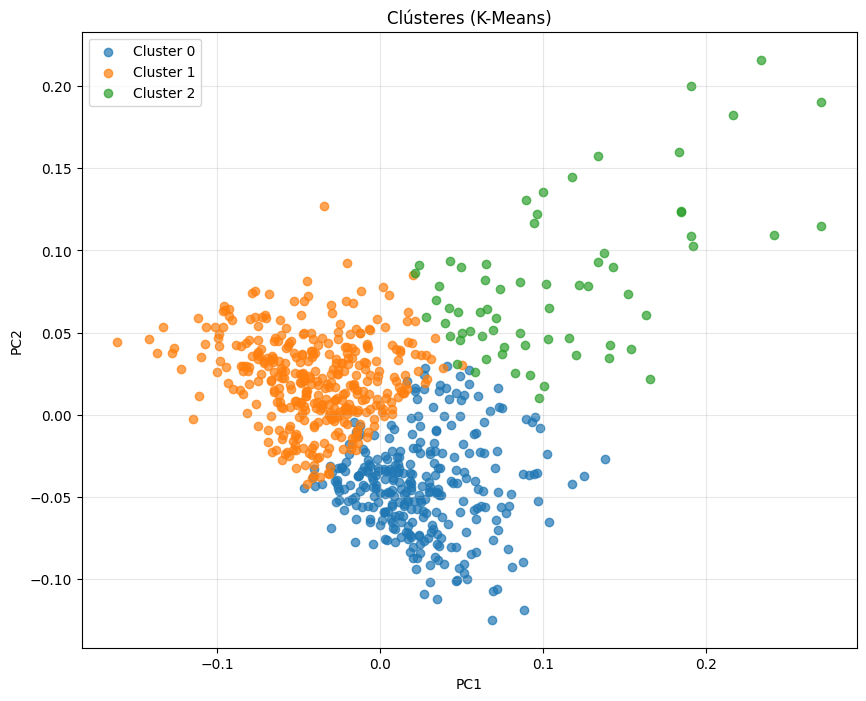

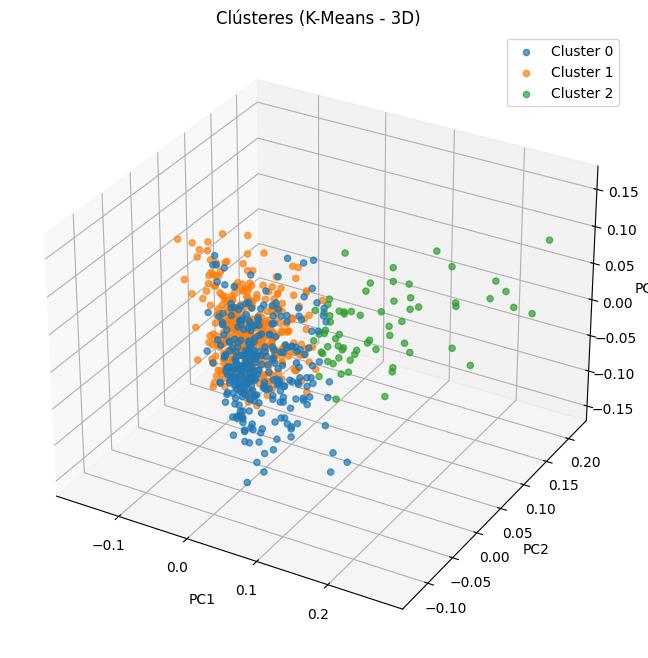

In [14]:
# Seleccionar el número óptimo de clústeres (basado en el método del codo)
# optimal_k = 4  # Cambiar según el gráfico del codo

# Aplicar K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(df[columns_per])

# Combinar los resultados de PCA con los clústeres
df_pca['cluster'] = df['cluster']

# Visualizar los clústeres en 2D
plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    cluster_data = df_pca[df_pca['cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.7)

plt.title('Clústeres (K-Means)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# (Opcional) Gráfico 3D con colores por clúster
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for cluster in range(optimal_k):
    cluster_data = df_pca[df_pca['cluster'] == cluster]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}', alpha=0.7)
ax.set_title('Clústeres (K-Means - 3D)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend()
plt.show()


#### Analicemos los países-año de los programas en cada cluster

In [15]:
# Crear un nuevo DataFrame para los resultados agrupados por clúster
clustered_data = df[['countryname', 'agno', 'cluster']]

# Agrupar por clúster y analizar
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    cluster_data = clustered_data[clustered_data['cluster'] == cluster]
    
    # Países y años únicos
    unique_countries = cluster_data['countryname'].unique()
    unique_years = cluster_data['agno'].unique()
    
    # Número de programas
    num_programs = len(cluster_data)
    num_countries = len(unique_countries)
    num_years = len(unique_years)
    
    # Mostrar resultados
    print(f"Número de programas: {num_programs}")
    print(f"Países ({num_countries}): {', '.join(unique_countries)}")
    print(f"Años ({num_years}): {', '.join(map(str, sorted(unique_years)))}")
    print("Programas (País-Año):")
    display(cluster_data[['countryname', 'agno']].reset_index(drop=True))



Cluster 0:
Número de programas: 303
Países (50): Albania, Argentina, Armenia, Australia, Austria, Azerbaijan, Belarus, Belgium, Bosnia-Herzegovina, Bulgaria, Canada, Chile, Czech Republic, Denmark, Ecuador, Finland, France, Georgia, Germany, Greece, Hungary, Iceland, Ireland, Israel, Italy, Japan, Latvia, Luxembourg, Mexico, Moldova, Montenegro, Netherlands, New Zealand, North Macedonia, Northern Ireland, Norway, Poland, Portugal, Romania, Russia, Serbia, Slovakia, Spain, Sri Lanka, Sweden, Switzerland, Turkey, Ukraine, United Kingdom, United States
Años (80): 1920, 1921, 1924, 1928, 1929, 1932, 1936, 1938, 1940, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2005, 2006, 2007, 

,countryname,agno
0,Albania,1997
1,Albania,2001
2,Argentina,1989
3,Armenia,1995
4,Armenia,1999
...,...,...
298,United States,1988
299,United States,2008
300,United States,2012
301,United States,2016



Cluster 1:
Número de programas: 369
Países (60): Argentina, Armenia, Australia, Austria, Belgium, Bolivia, Bosnia-Herzegovina, Brazil, Bulgaria, Canada, Chile, Colombia, Costa Rica, Croatia, Cyprus, Czech Republic, Denmark, Dominican Republic, Estonia, Finland, France, Georgia, Germany, Greece, Hungary, Iceland, Ireland, Italy, Japan, Latvia, Lithuania, Luxembourg, Malta, Mexico, Moldova, Montenegro, Netherlands, New Zealand, North Macedonia, Northern Ireland, Norway, Panama, Peru, Poland, Portugal, Romania, Russia, Serbia, Slovakia, Slovenia, South Africa, South Korea, Spain, Sweden, Switzerland, Turkey, Ukraine, United Kingdom, United States, Uruguay
Años (72): 1925, 1933, 1945, 1949, 1951, 1952, 1953, 1954, 1956, 1957, 1958, 1960, 1961, 1963, 1964, 1965, 1966, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 200

,countryname,agno
0,Argentina,1995
1,Argentina,1999
2,Argentina,2003
3,Argentina,2007
4,Argentina,2015
...,...,...
364,United Kingdom,2017
365,United Kingdom,2019
366,United States,1996
367,United States,2004



Cluster 2:
Número de programas: 67
Países (25): Argentina, Australia, Austria, Cyprus, Denmark, Finland, France, Greece, Hungary, Iceland, Ireland, Israel, Italy, Mexico, Moldova, New Zealand, Portugal, Romania, Russia, Slovenia, South Africa, Turkey, Ukraine, United Kingdom, United States
Años (51): 1946, 1948, 1949, 1950, 1951, 1953, 1954, 1956, 1957, 1959, 1961, 1962, 1963, 1967, 1972, 1973, 1974, 1975, 1976, 1977, 1979, 1980, 1983, 1985, 1987, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1998, 1999, 2000, 2001, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2018
Programas (País-Año):


,countryname,agno
0,Argentina,2011
1,Argentina,2013
2,Australia,1975
3,Australia,1996
4,Australia,1998
...,...,...
62,Ukraine,2006
63,United Kingdom,2001
64,United Kingdom,2005
65,United States,1992


In [16]:
# Análisis exploratorio por clúster
print("Análisis exploratorio por clúster:\n")

# Crear un DataFrame para mapear cada país con los clústeres y años en los que aparece
country_cluster_map = clustered_data.groupby('countryname').agg(
    Clusters=('cluster', lambda x: ", ".join(map(str, sorted(x.unique())))),
    Años=('agno', lambda x: ", ".join(map(str, sorted(x.unique())))),
    Frecuencia=('countryname', 'count')
).reset_index()
country_cluster_map.columns = ['País', 'Clusters', 'Años', 'Frecuencia']

# Mostrar los resultados para cada clúster
for cluster in range(optimal_k):
    print(f"\n--- Cluster {cluster} ---")
    
    # Filtrar los datos del clúster actual
    cluster_data = clustered_data[clustered_data['cluster'] == cluster]
    
    # Contar la cantidad de veces que cada país aparece en el clúster
    country_counts = cluster_data['countryname'].value_counts().reset_index()
    country_counts.columns = ['País', 'Frecuencia']
    
    # Agregar columnas de años y clústeres al resumen
    country_counts = country_counts.merge(
        country_cluster_map[['País', 'Clusters', 'Años']],
        on='País',
        how='left'
    )
    
    # Mostrar los resultados ordenados
    print("Países, frecuencias, años y clústeres (ordenados por aparición):")
    display(country_counts)


Análisis exploratorio por clúster:


--- Cluster 0 ---
Países, frecuencias, años y clústeres (ordenados por aparición):


,País,Frecuencia,Clusters,Años
0,United States,22,"0, 1, 2","1920, 1924, 1928, 1932, 1936, 1940, 1944, 1948..."
1,Denmark,18,"0, 1, 2","1945, 1947, 1950, 1953, 1957, 1960, 1964, 1966..."
2,Australia,17,"0, 1, 2","1946, 1949, 1951, 1954, 1955, 1958, 1961, 1963..."
3,Israel,16,"0, 2","1949, 1951, 1955, 1959, 1961, 1965, 1969, 1973..."
4,Canada,15,"0, 1","1945, 1949, 1953, 1957, 1958, 1962, 1963, 1965..."
5,Belgium,14,"0, 1","1946, 1949, 1950, 1954, 1958, 1961, 1965, 1968..."
6,Mexico,13,"0, 1, 2","1949, 1952, 1955, 1958, 1961, 1964, 1967, 1973..."
7,United Kingdom,11,"0, 1, 2","1945, 1950, 1951, 1955, 1959, 1964, 1966, 1970..."
8,Switzerland,11,"0, 1","1947, 1951, 1955, 1959, 1963, 1967, 1971, 1975..."
9,France,11,"0, 1, 2","1946, 1951, 1956, 1958, 1962, 1967, 1968, 1973..."



--- Cluster 1 ---
Países, frecuencias, años y clústeres (ordenados por aparición):


,País,Frecuencia,Clusters,Años
0,New Zealand,20,"0, 1, 2","1946, 1949, 1951, 1954, 1957, 1960, 1963, 1966..."
1,Sweden,20,"0, 1","1944, 1948, 1952, 1956, 1958, 1960, 1964, 1968..."
2,Norway,14,"0, 1","1945, 1949, 1953, 1957, 1961, 1965, 1969, 1973..."
3,Netherlands,14,"0, 1","1946, 1948, 1952, 1956, 1959, 1963, 1967, 1971..."
4,Germany,13,"0, 1","1949, 1953, 1957, 1961, 1965, 1969, 1972, 1976..."
5,Spain,12,"0, 1","1977, 1979, 1982, 1986, 1989, 1993, 1996, 2000..."
6,Austria,11,"0, 1, 2","1949, 1953, 1956, 1959, 1962, 1966, 1970, 1971..."
7,Ireland,10,"0, 1, 2","1948, 1951, 1954, 1957, 1961, 1965, 1969, 1973..."
8,Finland,10,"0, 1, 2","1945, 1948, 1951, 1954, 1958, 1962, 1966, 1970..."
9,Japan,9,"0, 1","1960, 1963, 1967, 1969, 1972, 1976, 1979, 1980..."



--- Cluster 2 ---
Países, frecuencias, años y clústeres (ordenados por aparición):


,País,Frecuencia,Clusters,Años
0,Iceland,11,"0, 1, 2","1946, 1949, 1953, 1956, 1959, 1963, 1967, 1971..."
1,Turkey,7,"0, 1, 2","1950, 1954, 1957, 1961, 1965, 1969, 1973, 1977..."
2,Australia,6,"0, 1, 2","1946, 1949, 1951, 1954, 1955, 1958, 1961, 1963..."
3,Portugal,6,"0, 1, 2","1975, 1976, 1979, 1980, 1983, 1985, 1987, 2009..."
4,Greece,4,"0, 1, 2","1974, 1977, 1981, 1985, 1989, 1990, 1993, 1996..."
5,Ireland,4,"0, 1, 2","1948, 1951, 1954, 1957, 1961, 1965, 1969, 1973..."
6,Finland,3,"0, 1, 2","1945, 1948, 1951, 1954, 1958, 1962, 1966, 1970..."
7,France,3,"0, 1, 2","1946, 1951, 1956, 1958, 1962, 1967, 1968, 1973..."
8,Argentina,2,"0, 1, 2","1989, 1995, 1999, 2003, 2007, 2011, 2013, 2015..."
9,United Kingdom,2,"0, 1, 2","1945, 1950, 1951, 1955, 1959, 1964, 1966, 1970..."


#### Revisemos centroides de los clusters

In [17]:
# Revisar los centroides
centroids = kmeans.cluster_centers_  # Centroides de los clústeres
centroids_df = pd.DataFrame(centroids, columns=columns_per)  # Crear un DataFrame para los centroides

# Redondear los valores para mejor visualización
centroids_df = centroids_df.round(4)

# Agregar un identificador para los clústeres
centroids_df.index = [f"Cluster {i}" for i in range(optimal_k)]

# Mostrar los centroides
print("Centroides de los Clústeres:")
display(centroids_df)


Centroides de los Clústeres:


,per101,per102,per103,per104,per105,per106,per107,per108,per109,per110,...,per605,per606,per607,per608,per701,per702,per703,per704,per705,per706
Cluster 0,0.0165,0.0050,0.0055,0.0229,0.0083,0.0179,0.0262,0.0090,0.0047,0.0015,...,0.0147,0.0233,0.0116,0.0034,0.0332,0.0020,0.0479,0.0137,0.0098,0.0424
Cluster 1,0.0066,0.0019,0.0015,0.0161,0.0037,0.0059,0.0232,0.0148,0.0021,0.0030,...,0.0395,0.0153,0.0082,0.0038,0.0292,0.0011,0.0342,0.0047,0.0072,0.0255
Cluster 2,0.0070,0.0047,0.0065,0.0110,0.0055,0.0062,0.0152,0.0087,0.0066,0.0026,...,0.0187,0.0252,0.0045,0.0009,0.0332,0.0022,0.0414,0.0074,0.0069,0.0223


#### Analicemos los Países y Períodos en Cada Clúster

In [18]:
# Análisis exploratorio por clúster
print("Análisis exploratorio por clúster:\n")

# Iterar por cada clúster
for cluster in range(optimal_k):
    print(f"\n--- Cluster {cluster} ---")
    
    # Filtrar los datos del clúster actual
    cluster_data = clustered_data[clustered_data['cluster'] == cluster]
    
    # Contar la cantidad de veces que cada país aparece en el clúster
    country_counts = cluster_data['countryname'].value_counts().reset_index()
    country_counts.columns = ['País', 'Frecuencia']
    
    # Agregar una columna con los años en los que aparece cada país
    country_counts['Años'] = country_counts['País'].apply(
        lambda country: ", ".join(map(str, cluster_data[cluster_data['countryname'] == country]['agno'].unique()))
    )
    
    # Mostrar los resultados ordenados
    print("Países, frecuencias y años (ordenados por aparición):")
    display(country_counts)


Análisis exploratorio por clúster:


--- Cluster 0 ---
Países, frecuencias y años (ordenados por aparición):


,País,Frecuencia,Años
0,United States,22,"1920, 1924, 1928, 1932, 1936, 1940, 1944, 1948..."
1,Denmark,18,"1945, 1947, 1950, 1953, 1957, 1960, 1964, 1966..."
2,Australia,17,"1946, 1949, 1951, 1954, 1955, 1958, 1961, 1963..."
3,Israel,16,"1949, 1951, 1955, 1959, 1961, 1965, 1969, 1973..."
4,Canada,15,"1945, 1949, 1957, 1958, 1962, 1963, 1968, 1972..."
5,Belgium,14,"1946, 1950, 1954, 1958, 1961, 1965, 1968, 1971..."
6,Mexico,13,"1949, 1952, 1955, 1958, 1961, 1964, 1967, 1973..."
7,United Kingdom,11,"1945, 1950, 1951, 1955, 1959, 1966, 1970, 1974..."
8,Switzerland,11,"1947, 1951, 1955, 1959, 1963, 1967, 1975, 1979..."
9,France,11,"1958, 1962, 1967, 1968, 1973, 1978, 1981, 1986..."



--- Cluster 1 ---
Países, frecuencias y años (ordenados por aparición):


,País,Frecuencia,Años
0,New Zealand,20,"1951, 1954, 1957, 1960, 1966, 1969, 1972, 1975..."
1,Sweden,20,"1952, 1956, 1958, 1960, 1964, 1968, 1970, 1973..."
2,Norway,14,"1957, 1965, 1969, 1973, 1977, 1985, 1989, 1993..."
3,Netherlands,14,"1963, 1971, 1972, 1977, 1986, 1989, 1998, 2002..."
4,Germany,13,"1961, 1965, 1969, 1972, 1976, 1980, 1987, 1990..."
5,Spain,12,"1979, 1982, 1986, 1989, 1993, 1996, 2000, 2004..."
6,Austria,11,"1970, 1975, 1983, 1990, 1999, 2002, 2006, 2008..."
7,Ireland,10,"1951, 1977, 1981, 1987, 1989, 1992, 1997, 2002..."
8,Finland,10,"1975, 1979, 1987, 1991, 1995, 2003, 2007, 2011..."
9,Japan,9,"1972, 1979, 1980, 2000, 2003, 2005, 2009, 2012..."



--- Cluster 2 ---
Países, frecuencias y años (ordenados por aparición):


,País,Frecuencia,Años
0,Iceland,11,"1946, 1949, 1953, 1956, 1959, 1963, 1967, 1974..."
1,Turkey,7,"1950, 1954, 1957, 1977, 1987, 1991, 1999"
2,Australia,6,"1975, 1996, 1998, 2001, 2004, 2007"
3,Portugal,6,"1976, 1979, 1980, 1983, 1985, 1987"
4,Greece,4,"1977, 1990, 1993, 2012"
5,Ireland,4,"1954, 1957, 1961, 1973"
6,Finland,3,"1948, 1962, 1972"
7,France,3,"1946, 1951, 1956"
8,Argentina,2,"2011, 2013"
9,United Kingdom,2,"2001, 2005"


In [20]:
clustered_data

,countryname,agno,cluster
0,Albania,1997,0
1,Albania,2001,0
2,Argentina,1989,0
3,Argentina,1995,1
4,Argentina,1999,1
...,...,...,...
734,United States,2008,0
735,United States,2012,0
736,United States,2016,0
737,United States,2020,0
